In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pylattica.core import SynchronousRunner, Lattice, PeriodicStructure, SimulationState

# Conway's Game of Life in pylattica

In this guide, we show how one can use the pieces provided by `pylattica` to implement Conway's Game of Life. Conway's Game of Life is a famous cellular automaton defined by mathematician John Conway. It demonstrates the way that very complex phenomena can emerge from simple local interactions, and has been studied extensively.

In Conway's Game of Life, a 2D square grid of cells are labelled as "alive" or "dead". Then, as the simulation progresses, the cell states flip between "dead" and "alive" depending on how many living cells surround them.

Before we begin though, take a quick look at the [Wikipedia Article](https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life) for the Game of Life to understand what the model is.

In particular, note that the rules describing the game are simple:

1. Any live cell with fewer than two live neighbours dies, as if by underpopulation.
2. Any live cell with two or three live neighbours lives on to the next generation.
3. Any live cell with more than three live neighbours dies, as if by overpopulation.
4. Any dead cell with exactly three live neighbours becomes a live cell, as if by reproduction.

In this notebook, we will implement this model using `pylattica` and show some of the libarary's visualization capabilities.

## Implementing the Update Rule

Let's start this implementation by writing out the update rule above in code. We'll do this by implementing a function that takes the old state of a cell and the states of the neighboring cells, and returns the new state. We're not using anything from `pylattica` at all right now, just translating the rules of the Game into codee.

In [3]:
def update_state(old_state, neighboring_states):
    alive_neighbor_count = 0
    dead_neighbor_count = 0
    
    for state in neighboring_states:
        if state == "alive":
            alive_neighbor_count += 1
        else:
            # since all cells are either alive or dead, nothing else
            dead_neighbor_count += 1
    
    # Now, we can implement the rules in python logic:
    if old_state == "alive":
        if alive_neighbor_count < 2:
            return "dead"
        elif alive_neighbor_count == 2 or alive_neighbor_count == 3:
            return "alive"
        elif alive_neighbor_count > 3:
            return "dead"
    elif old_state == "dead":
        if alive_neighbor_count == 3:
            return "alive"
    
    return old_state
    

This is a bit verbose, but we've written it that way just to emphasize the direct mapping of logical statements here to the rules from the Wikipedia article. Let's try out some hypothetical situations:

In [4]:
print("alive cell, 2 dead, 2 alive neighbors:")
print("result:", update_state("alive", ["alive", "dead", "alive", "dead"]))
print("")
print("alive cell, 1 dead, 4 alive neighbors:")
print("result:", update_state("alive", ["alive", "alive", "alive", "alive"]))
print("")
print("dead cell, 1 dead, 3 alive neighbors:")
print("result:", update_state("dead", ["alive", "alive", "alive", "dead"]))

alive cell, 2 dead, 2 alive neighbors:
result: alive

alive cell, 1 dead, 4 alive neighbors:
result: dead

dead cell, 1 dead, 3 alive neighbors:
result: alive


The rule looks like it's working. Let's see how we can use pylattica to make this rule into a whole simulation.

## Setting Up The Simulation Structure

We know that Conway's Game of Life has cells that are either dead or alive. These cells are arranged on a _2D square grid_. We refer to this grid as the _lattice_ on which the simulation evolves. One of the core functions of `pylattica` is to make it easy to define such lattices.

To construct our 2D square grid, we will use the `Lattice` class.

> **NOTE**: For detailed illustrations of the behavior of the `Lattice` class, please see the [Lattice guide](/guides/constructing_lattices.ipynb).

In [5]:
lattice = Lattice([
    [1, 0],
    [0, 1]
])

Now that we've defined the [unit cell](https://en.wikipedia.org/wiki/Unit_cell) of our lattice, we can build the structure of our simulation. This `Lattice` object defines the shape of a single square grid tile. We build a larger grid of tiles using the `PeriodicStructure` object.

We'll place a single simulation site in the center of each of these tiles. We specify this arrangement using a "motif", as shown below.

> **NOTE**: For more detailed instructions for making `PeriodicStructure`s, please see the [PeriodicStructure guide](../guides/periodic_structure.ipynb)

In this case, we are specifying a single site at each lattice point.

In [50]:
motif = [
    [0, 0]
]

structure = PeriodicStructure.build_from(lattice, (20,20), motif)

The lines of code above create a 10 x 10 square grid with periodic boundary conditions (see the [`PeriodicStructure` guide](../guides/periodic_structures.ipynb) for details on periodicity). This structure will be used to define the neighbors of each cell.

Before we defined the neighborhood, let's set up a starting state for our simulation.

### Simulation State

We can construct an empty simulation state using the structure we generated:

> **NOTE**: For more details about the `SimulationState` object, see the [SimulationState guide](../guides/simulation_state.ipynb)

In [51]:
initial_state = SimulationState.from_struct(structure)

This state object has entries for each of the sites in the structure. We can see this by grabbing an arbitrary site from the simulation structure.

In [52]:
arb_site = structure.id_at((0, 0))

print("State for site", arb_site, ":", initial_state.get_site_state(arb_site))

State for site 0 : {'_site_id': 0}


So far, this state is empty. There is no information contained in that dictionary that is specific to our simulation.

In our simulation, each cell site is either "dead" or "alive". Since `SimulationState`s can contain any key value mapping, let's invent a convention for representing whether each site is alive or dead.

The key for our state will be "state" and the value will be either "alive" or "dead". We can set up an initial simulation state by iterating over all the site IDs in the structure, and assigning a random dead or alive state to each of them.

In [53]:
import random

dead = "DEAD"
alive = "ALIVE"
state = "STATE"

state_choices = [dead, alive]

for site_id in structure.site_ids:
    initial_state.set_site_state(site_id, {
        state: random.choice(state_choices)
    })
    
print("State for site", arb_site, ":", initial_state.get_site_state(arb_site))

State for site 0 : {'_site_id': 0, 'STATE': 'DEAD'}


That's it! Now we can do a quick visualization to see what the simulation state looks like. `pylattica` only supports visualization of square grid structures. We can use the `SquareGridArtist2D` and `CellArtist` classes for this.

The `CellArtist` defines the color that should be shown for each cell, and the legend label for that cell, as a function of it's state. We define ours like this: 

In [54]:
from pylattica.visualization import CellArtist

class GoLCellArtist(CellArtist):
    
    def get_color_from_cell_state(self, cell_state):
        if cell_state[state] == dead:
            return (0,100,150)
        else:
            return (255, 255, 150)
    
    def get_cell_legend_label(self, cell_state):
        if cell_state[state] == dead:
            return "Dead"
        else:
            return "Alive"

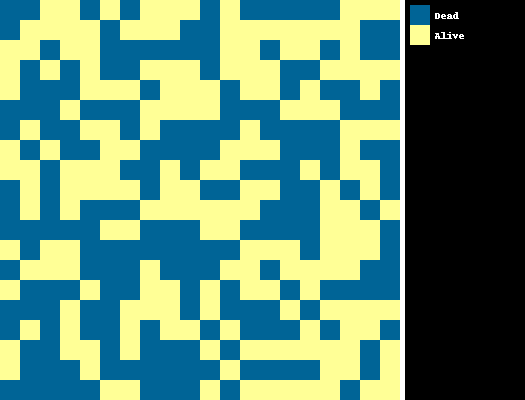

In [69]:
from pylattica.visualization import SquareGridArtist2D

grid_artist = SquareGridArtist2D(structure, cell_artist=GoLCellArtist())

grid_artist.jupyter_show(initial_state, cell_size=20)

#### Site Neighborhoods

The final ingredient to the pylattica model is the concept of a neighborhood. A neighborhood is simply the set of other sites that are considered neighbors. There are many different neighborhood specifications that are possible including classic neighborhoods for 2D square grids like [Moore Neighborhoods](https://en.wikipedia.org/wiki/Moore_neighborhood) and [Von Neumann Neighborhoods](https://en.wikipedia.org/wiki/Von_Neumann_neighborhood).

You can specify neighborhoods in many different ways such as:

- All cells within a certain distance (actually Moore and Von Neumann neighborhoods both fall into this category, but with different distance cutoffs, or different distance metrics)
- All cells given by moving in a certain direction
- A random subset of surrounding cells

As specified in the Game of Life Wikipedia article, we need a Moore neighborhood (includes the cells in each of the cardinal directions and the diagonal directions). Though `pylattica` comes with a `MooreNeighborhood` built in under the square grid module, we will build ours from scratch.

> **NOTE**: To learn more about `pylattica` `Neighborhood`s, take a look at the [Neighborhood guide](../guides/neighborhoods.ipynb)

In [56]:
from pylattica.core.neighborhood_builders import DistanceNeighborhoodBuilder

To build a Moore Neighborhood, we will first observe that in the Moore Neighborhood, each neighbor is within 1.5 cell widths from the central cell. Using this observation, we know we can use a `DistanceNeighborhoodBuilder` for our use case. This builder makes assigns every cell neighbors which are within some specified cutoff radius.

Here's how it works.

In [57]:
builder = DistanceNeighborhoodBuilder(cutoff=1.5)  
nb_hood = builder.get(structure)

100%|██████████████████████████████████████| 400/400 [00:01<00:00, 327.85it/s]


We can use the neighborhood to get the neighbors of any site, let's try the one at (5, 5).

In [58]:
site = structure.site_at((5,5))
nbs = nb_hood.neighbors_of(site['_site_id'])

What do we expect the locations of these neighboring sites to be?

In [59]:
for nb_id in nbs:
    site = structure.get_site(nb_id)
    print(f'Neighbor with ID {nb_id} is at {site["_location"]}')

Neighbor with ID 86 is at [4. 6.]
Neighbor with ID 106 is at [5. 6.]
Neighbor with ID 124 is at [6. 4.]
Neighbor with ID 84 is at [4. 4.]
Neighbor with ID 125 is at [6. 5.]
Neighbor with ID 126 is at [6. 6.]
Neighbor with ID 104 is at [5. 4.]
Neighbor with ID 85 is at [4. 5.]


As expected, these eight coordinate pairs correspond to the sites above, below, right and left, and diagonal of the site at (5, 5).

## Implementing the Simulation Controller

We've defined the possible states in our system, and initialized a starting point. The next step is move our update rule from before into a format the pylattica can understand. For this, we have to implement a new `Controller` class.

In [60]:
from pylattica.core import BasicController, SimulationState
from pylattica.discrete.state_constants import DISCRETE_OCCUPANCY
from pylattica.core.simulation_state import SITES

To accomplish this, we need to implement two methods in our controller class. The first, `pre_run` provides an opportunity to do any setup you'd like to before the simulation runs. It accepts as parameters the initial state of the simulation, and the structure underlying the state.

All we'll do is setup a neighborhood based on the structure that we can use later.

Second, we need to implement the `get_state_update` method. This is the fundamental piece of the controller. This method takes a site for which a new state should be calculated and the entire current simulation state. We can do any calculation we want to figure out the new state, but, armed with our neighborhood, and the update rule we implemented earlier, we have enough to create Conway's Game of Life.

In [82]:
def update_state(old_state, neighboring_states):
    alive_neighbor_count = 0
    dead_neighbor_count = 0
    
    for state in neighboring_states:
        if state == alive:
            alive_neighbor_count += 1
        else:
            # since all cells are either alive or dead, nothing else
            dead_neighbor_count += 1
    
    # Now, we can implement the rules in python logic:
    if old_state == alive:
        if alive_neighbor_count < 2:
            return dead
        elif alive_neighbor_count == 2 or alive_neighbor_count == 3:
            return alive
        elif alive_neighbor_count > 3:
            return dead
    elif old_state == dead:
        if alive_neighbor_count == 3:
            return alive
        else:
            return dead
    
    return old_state

class GameOfLifeController(BasicController):
    
    def __init__(self, structure):
        self.structure = structure
    
    def pre_run(self, initial_state):
        # Before the simulation runs, we build a neighborhood based on the 
        # structure of the current simulation.
        self.neighborhood = DistanceNeighborhoodBuilder(1.5).get(self.structure)
    
    def get_state_update(self, site_id, curr_state: SimulationState):
        neighbor_site_ids = self.neighborhood.neighbors_of(site_id)
        
        neighbor_states = []
        for nb_site_id in neighbor_site_ids:
            neighbor_state = curr_state.get_site_state(nb_site_id)
            neighbor_states.append(neighbor_state[state])

        current_state = curr_state.get_site_state(site_id)[state]
        
        new_state = update_state(current_state, neighbor_states)
        # print(site_id, current_state, neighbor_states, new_state)
        updates = {
            state: new_state
        }
        return updates
            

Finally, we instantiate our controller and a `Runner`, and let the simulation run for a few steps.

In [83]:
controller = GameOfLifeController(structure)
runner = SynchronousRunner(parallel = True)
result = runner.run(initial_state, controller, 100)

100%|█████████████████████████████████████| 100/100 [00:00<00:00, 1013.13it/s]


Using the visualization tool we instantiated earlier, we can see the results here!

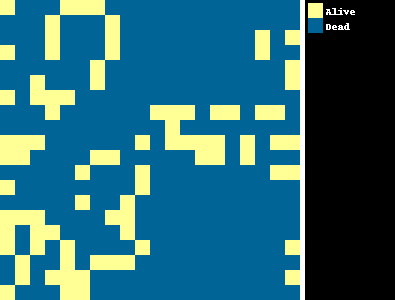

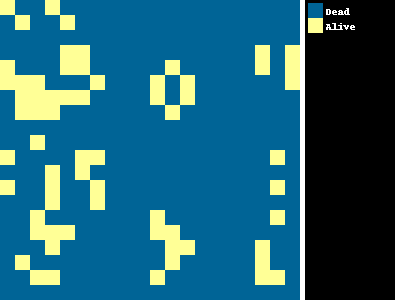

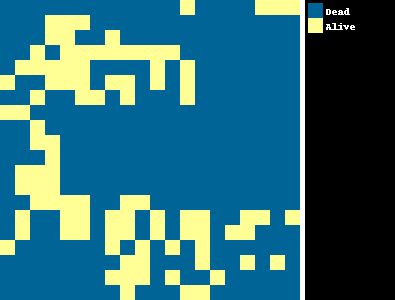

In [87]:
grid_artist.jupyter_show(result.get_step(10), cell_size=15)
grid_artist.jupyter_show(result.get_step(20), cell_size=15)
grid_artist.jupyter_show(result.get_step(30), cell_size=15)

In [88]:
from pylattica.visualization import ResultArtist
res_artist = ResultArtist(grid_artist, result)
res_artist.to_gif("out.gif", wait=0.1)